# Tutorial on Wake-Sleep and Auto-Encoding Variational Bayes (AEVB)

Created by Lisa Lee <lslee@cs.cmu.edu>

**Acknowledgements**: This tutorial was modified from https://jmetzen.github.io/2015-11-27/vae.html. Students can refer to this link if they'd like, but all useful code from that link, and more, are already included in this notebook.


### Instructions

This notebook already contains a working implementation of AEVB, also known as Variational Autoencoder (VAE).

* Copy this notebook to your Google Drive by selecting "OPEN IN PLAYGROUND", then "COPY TO DRIVE".

* After completing the TODO's, please submit your modified .ipynb notebook (containing your Wake-Sleep and $\mathcal{L}_k$ implementations) on Gradescope. (In Colab: Select "File" > "Download .ipynb" to download the notebook, then upload the notebook to Gradescope.)

* Please be careful not to publish your solutions on the web, as that would go against academic integrity policies. By default, your Colab notebooks are set to private.

You are not required to use the provided AEVB implementation. If you want to implement both AEVB and Wake-Sleep from scratch, or use a different framework such as PyTorch, you can replace the VariationalAutoencoder class with your own in the notebook. But make sure that AEVB and Wake-Sleep share mostly the same code (e.g., use exactly the same architectures for the recognition and generation networks) to ensure fair comparison.

### References

1. Hinton et al., "The wake-sleep algorithm for
unsupervised neural networks", Science 1995. [[PDF](http://www.cs.toronto.edu/~fritz/absps/ws.pdf)]

2. Dayan, "Helmholtz machines and wake-sleep learning", 2000. [[PDF](https://pdfs.semanticscholar.org/dd8c/da00ccb0af1594fbaa5d41ee639d053a9cb2.pdf)]

3. Kingma & Welling, "Auto-encoding variational bayes", 2013. [[arXiv](https://arxiv.org/abs/1312.6114)]

4. Doersch, "Tutorial on variational autoencoders", 2016. [[arXiv](https://arxiv.org/abs/1606.05908)]


### How to save files

You can save plots by right-clicking an image and selecting "Save Image As..."

If you want to save files (plots, model checkpoints, etc.) directly, there are several options:

1. Mount Google Drive to your Colab session. You will need to grant access to your Google Drive. Here's an example code snippet:

```
from google.colab import drive
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/file.txt', 'w') as f:
  f.write('content')
```

2. Run the notebook locally. You will need to install Jupyter, TensorFlow, and other dependencies. You can save a copy of the notebook by going to "File" > "Download .ipynb".


## I. Preliminaries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(0)

/Users/angelhernandez/anaconda/lib/python3.6/site-packages/h5py/__init__.py:75: UserWarning: h5py is running against HDF5 1.8.17 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



The following code downloads the MNIST dataset. (You can ignore the warnings for this assignment.)

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets('mnist', one_hot=True)

# Print dataset shapes.
# - Images are 28 x 28.
# - Labels are one of 10 digits, {0, 1, ..., 9}.
print()
print('Train images shape:', mnist.train.images.shape)
print('Train labels shape:', mnist.train.labels.shape)

print('Test images shape:', mnist.test.images.shape)
print('Test labels shape:', mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Train images shape: (55000, 784)
Train labels shape: (55000, 10)
Test images shape: (10000, 784)
Test labels shape: (10000, 10)


Now you can play around with the MNIST dataset. Below, we provide a function to visualize the 28 x 28 image matrices.

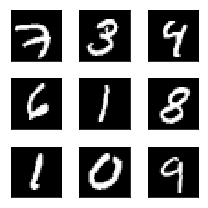

In [3]:
def plot_mnist(X, nrows=10, ncols=10):
    """
    Plots the given MNIST digits on a grid of size (nrows x ncols).
    """
    N = len(X)
    assert N <= nrows * ncols

    # Plot each 28 x 28 image.
    plt.figure(figsize=(nrows, ncols))
    for i in range(N):
        x = X[i].reshape(28, 28)

        plt.subplot(nrows, ncols, i + 1)
        fig = plt.imshow(x, vmin=0, vmax=1, cmap="gray")

        # Hide axes. (Both x-axis and y-axis range from 0 to 27.)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()
    
    # If you want to save the plot using plt.savefig(fig_path), please
    # follow the instructions above (under "How to save files").

# Plot digits.
plot_mnist(mnist.train.images[:9], nrows=3, ncols=3)

## II. Implementation

We now define a class "VariationalAutoencoder" that implements the AEVB learning algorithm. The VAE is trained incrementally with mini-batches using partial fit. The trained model can be used to reconstruct unseen input, generate new samples, and map inputs to the latent space.

Model specification:

* Both the generative network $p_{\mathbf{\theta}}(\mathbf{x} \mid \mathbf{z})$ and the recognition network $q_{\mathbf{\phi}}(\mathbf{z} \mid \mathbf{x})$ are parametrized by neural networks with one hidden layer that consists of 512 ReLU neurons and a latent space dimension of 2. The weights are initialized by sampling from $\mathcal{N}(0, 0.01)$, and biases are initialized to zeros.

* Since $\mathbf{x}$'s take values in [0, 1], the output layer of the generation network that represents $p_{\mathbf{\theta}}(\mathbf{x} \mid \mathbf{z})$ should consist of sigmoid neurons.

* The variational distribution $q_{\mathbf{\phi}}(\mathbf{z} \mid \mathbf{x})$ is represented by a Gaussian of the form $\mathcal{N}(\mathbf{z}; \mathbf{\mu}_{\mathbf{\phi}}(\mathbf{x}), \mathbf{\Sigma}^2_{\mathbf{\phi}}(\mathbf{x})I)$, where $\mathbf{\mu}_{\mathbf{\phi}}(\mathbf{x})$ and $\mathbf{\Sigma}_{\mathbf{\phi}}(\mathbf{x})$ are linear outputs of the recognition network.

### TODO's
The code will run as is, but you will later need to implement the following TODO's specified throughout the code:

1. Wake-Sleep algorithm.  You just need to fill in the TODO's inside the VariationalAutoencoder class, under the "if self.algo == 'wake-sleep':" statements in the class methods _create_network(), _create_loss_optimizer(), and _partial\_fit(). The remaining parts (e.g., architectures for the recognition and generation networks) should remain the same.
  - You may need different learning rates for the Wake-phase and Sleep-phase. In the reference implementation, we used learning rates 1e-3 for the Wake-phase and 1e-5 for the Sleep-phase. We used a sample size of 100 to compute the Monte Carlo estimate of the gradient for the Sleep objective.
  - The optional argument "var_list" in tf.train.AdamOptimizer() lets you specify a list of tf.Variable to update to minimize the loss.

2. Computation of the lower bound $\mathcal{L}_k$ as defined in Section 1.4:
$$
\mathcal{L}_k(\mathbf{x}) = \mathbb{E}_{\mathbf{z}^{(1)}, \dots, \mathbf{z}^{(k)} \sim q_{\mathbf{\phi}}(\mathbf{z} \mid \mathbf{x})} \left[ \log \frac{1}{k} \sum_{i=1}^k \frac{p_{\mathbf{\theta}}(\mathbf{x}, \mathbf{z}^{(i)})}{q_{\mathbf{\phi}}(\mathbf{z}^{(i)} \mid \mathbf{x})} \right]
$$

In [4]:
class VariationalAutoencoder():
    def __init__(self, algo='vae', learning_rate=0.001, k=500, ckpt_path=""):
        """
        Args:
          algo (str): The algorithm. Value must be 'vae' or 'wake-sleep'.
          learning_rate (float): The learning rate.
          k (int): Used to compute L_k as defined in Section 1.4.
          ckpt_path (str): Model checkpoint path
        """
        assert algo in ['vae', 'wake-sleep']
        self.algo = algo
        self.learning_rate = learning_rate
        self.k = k

        self.z_dim = 2         # Latent space dimension
        self.input_size = 784  # MNIST image size: 28*28

        self._create_network()
        self._create_loss_optimizer()
        self._calculate_L_100()
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sess = tf.Session()

        if ckpt_path:
            self.load_model(ckpt_path)
        else:
            self.sess.run(init)

    def _init_weights(self, in_dim, out_dim):
        """Return random values of shape (in_dim, out_dim) from a gaussian
        N(0, 0.01) distribution."""
        return tf.random_normal((in_dim, out_dim), mean=0.0, stddev=0.1,
                                dtype=tf.float64)

    def _initialize_weights(self, n_hidden_r=512, n_hidden_g=512):
        network_weights = dict()
        network_weights['weights_r'] = {
            'h1': tf.Variable(self._init_weights(self.input_size, n_hidden_r)),
            'out_mean': tf.Variable(self._init_weights(n_hidden_r, self.z_dim)),
            'out_log_sigma': tf.Variable(
                self._init_weights(n_hidden_r, self.z_dim))
        }
        network_weights['biases_r'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_r], dtype=tf.float64)),
            'out_mean': tf.Variable(tf.zeros([self.z_dim], dtype=tf.float64)),
            'out_log_sigma': tf.Variable(
                tf.zeros([self.z_dim], dtype=tf.float64))
        }
        network_weights['weights_g'] = {
            'h1': tf.Variable(self._init_weights(self.z_dim, n_hidden_g)),
            'out_mean': tf.Variable(
                self._init_weights(n_hidden_g, self.input_size)),
            'out_log_sigma': tf.Variable(
                self._init_weights(n_hidden_g, self.input_size))
        }
        network_weights['biases_g'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_g], dtype=tf.float64)),
            'out_mean': tf.Variable(
                tf.zeros([self.input_size], dtype=tf.float64)),
            'out_log_sigma': tf.Variable(
                tf.zeros([self.input_size], dtype=tf.float64))
        }
        return network_weights

    def _create_network(self):
        # Input MNIST images
        self.x = tf.placeholder(tf.float64, [None, self.input_size])

        # Initialize autoencoder network weights and biases.
        self.network_weights = self._initialize_weights()

        # Use recognition network to determine mean and (log) variance of the
        # Gaussian distribution in latent space.
        #   z_mean:         (batch_size, 2)
        #   z_log_sigma_sq: (batch_size, 2)
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(
            self.x,
            self.network_weights["weights_r"],
            self.network_weights["biases_r"])

        # Draw one sample z from Gaussian distribution.
        batch_size = tf.shape(self.x)[0]
        eps = tf.random_normal((batch_size, self.z_dim), 0, 1, 
                               dtype=tf.float64)
#         eps = tf.random_normal((batch_size, self.z_dim), 0, 1, 
#                                dtype=tf.float64,seed=0) # dead 
        # z = mu + sigma * epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine the mean of the Bernoulli distribution of
        # the reconstructed input.
        self.x_reconstr_mean = self._generator_network(
            self.z,  # [B * L, 2]
            self.network_weights["weights_g"],
            self.network_weights["biases_g"])

        if self.algo == 'wake-sleep':
            # TODO: You may need to add variables for the sleep-phase.
            # sample a z
            self.z_sleep = tf.random_normal((batch_size, self.z_dim), 0, 1, dtype=tf.float64)
#             self.z_sleep = tf.random_normal((batch_size, self.z_dim), 0, 1, dtype=tf.float64,seed=0) # dead 
    
            # feed z into the generative network to get x
            self.x_reconstr_mean_sleep = self._generator_network(
            self.z_sleep,  # [B, 2] BATCH SIZE = L
            self.network_weights["weights_g"],
            self.network_weights["biases_g"])
            
            # sample x from Bernoulli
            dist = tfp.distributions.Bernoulli(probs = self.x_reconstr_mean_sleep)
            self.x_sleep = tf.cast(dist.sample(),dtype = tf.float64)
            
            # feed x into the recogniton network to get z_mean and z_sigma
            self.z_mean_sleep, self.z_log_sigma_sq_sleep = self._recognition_network(
            self.x_sleep,
            self.network_weights["weights_r"],
            self.network_weights["biases_r"])

        # TODO: You may need to add variables for computing the lower bound L_k.

    def _recognition_network(self, x, weights, biases):
        # Generate probabilistic encoder (recognition network), which maps
        # inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']),
                                  biases['b1']))
        z_mean = tf.add(tf.matmul(layer, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = tf.add(
                   tf.matmul(layer, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, z, weights, biases):
        # Generate probabilistic decoder (decoder network), which maps points in
        # latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer = tf.nn.relu(tf.add(tf.matmul(z, weights['h1']), 
                                           biases['b1'])) 
        x_reconstr_mean = tf.nn.sigmoid(
                    tf.add(tf.matmul(layer, weights['out_mean']), 
                    biases['out_mean']))
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        # Reconstruction term
        reconstr_term = (self.x * tf.log(1e-10 + self.x_reconstr_mean)
                + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean))
        reconstr_loss = -tf.reduce_sum(reconstr_term, 1)
        self.reconstr_loss = tf.reduce_sum(reconstr_term, 1)
        
        if self.algo == 'vae':
            latent_term = (1 + self.z_log_sigma_sq - tf.square(self.z_mean)
                             - tf.exp(self.z_log_sigma_sq))
            latent_loss = -0.5 * tf.reduce_sum(latent_term, 1)

            # Average loss over batch.
            self.cost = tf.reduce_mean(reconstr_loss + latent_loss) 
#             self.cost = tf.reduce_mean(reconstr_loss) # dead

            # Optimize loss.
            self.optimizer = tf.train.AdamOptimizer(
                    learning_rate=self.learning_rate).minimize(self.cost)
        elif self.algo == 'wake-sleep':
            # TODO: Implement Wake-Sleep optimizers.
            # Hints:
            #   - You can use different learning rates for wake-phase and
            #     sleep-phase.
            #   - The optional argument `var_list` lets you specify a list of
            #     tf.Variable to update to minimize loss. Example:
            #     tf.train.AdamOptimizer(learning_rate=lr).minimize(cost, var_list=[...])
            
            # wake cost
            self.cost_wake = tf.reduce_mean(reconstr_loss)
            
            #sleep cost
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalDiag(loc=self.z_mean_sleep,scale_diag = tf.sqrt(tf.exp(self.z_log_sigma_sq_sleep)))
            self.prob = tf.cast(mvn.log_prob(self.z_sleep),tf.float64)
            self.cost_sleep = -tf.reduce_mean(self.prob)
            
            self.optimizer_wake = tf.train.AdamOptimizer(
                learning_rate=1e-5).minimize(self.cost_wake,
                                                           var_list=[self.network_weights['weights_g'],
                                                                     self.network_weights['biases_g']])
            self.optimizer_sleep = tf.train.AdamOptimizer(
            learning_rate=1e-5).minimize(self.cost_sleep,
                                                       var_list = [self.network_weights['weights_r'],
                                                                   self.network_weights['biases_r']])
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        if self.algo == 'vae':
            opt, cost = self.sess.run((self.optimizer, self.cost),feed_dict={self.x: X})
            return [cost,0]
        
        elif self.algo == 'wake-sleep':
            wake_opt, wake_cost = self.sess.run((self.optimizer_wake,self.cost_wake),feed_dict={self.x: X})
            sleep_opt, sleep_cost = self.sess.run((self.optimizer_sleep,self.cost_sleep),feed_dict={self.x:X})
#             sleep_opt, sleep_cost,ll = self.sess.run((self.optimizer_sleep,self.cost_sleep,tf.log(1e-10 + self.prob)),feed_dict={self.x:X}) # dead
            
            return [wake_cost,sleep_cost]

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution. We could alternatively
        # sample from Gaussian distribution.
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.z_dim)
        # Note: This maps to mean of distribution. We could alternatively
        # sample from Gaussian distribution.
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    def _calculate_L_100(self):
        tfd = tfp.distributions
        bsize = self.x.shape[0]
        
        z = tf.random_normal((100, self.z_dim), 0, 1, dtype=tf.float64) 
        param_x = self._generator_network(z,
                                         self.network_weights["weights_g"],
                                         self.network_weights["biases_g"])
        qz_mean, qz_log_sigma_sq = self._recognition_network(self.x,
                                                             self.network_weights["weights_r"],
                                                             self.network_weights["biases_r"])
        p_mvn = tfd.MultivariateNormalDiag(loc=[0,0],scale_diag = [1,1])
        q_mvn = tfd.MultivariateNormalDiag(loc= qz_mean,scale_diag = qz_log_sigma_sq)
        
        self.prob_z = tf.cast(p_mvn.log_prob(tf.cast(z,tf.float32)),tf.float64)
        self.prob_x = tf.reduce_sum((self.x * tf.log(1e-10 + param_x) + (1-self.x) * tf.log(1e-10 + 1 - param_x)),axis=1)
        self.qrob_z = tf.cast(q_mvn.log_prob(z),tf.float64)
        self.L100 = tf.log(tf.reduce_mean(tf.exp(tf.cast(self.prob_z + self.prob_x - self.qrob_z,tf.float64))))


    def save_model(self, ckpt_path):
        self.saver.save(self.sess, ckpt_path)
        print("Saved model to " + ckpt_path)

    def load_model(self, ckpt_path):
        self.saver.restore(self.sess, ckpt_path)
        print("Loaded model from " + ckpt_path)

In [ ]:
# dist = tfp.distributions.Bernoulli(probs = np.array([[0.1,1.,1.],[1.,1.,1.]]))
# sample = dist.sample()
tfd = tfp.distributions
mvn = tfd.MultivariateNormalDiag(loc=[0,0],scale_diag = [1,1])
prob = mvn.prob(np.array([[1,1],[5,5]]))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(prob)

In [ ]:
import scipy
scipy.stats.norm(loc=0,scale=0.5).pdf(0)

In [ ]:
np.log(1e-230)

## III. Training

The following code trains VAE on the MNIST dataset for 100 epochs using batch size 100.

### TODO

Train both VAE and Wake-Sleep for 100 epochs using batch size 100.

* For each algorithm, plot $\mathcal{L}_{100}^\text{test}$ vs. the epoch number.
  - To save computation time, you can evaluate $\mathcal{L}_{100}$ every 10 epochs.
  - Use the full test set $\{\mathbf{x}^{(i)}\}_{i=1}^n$ to evaluate $\mathcal{L}_{100} = \frac{1}{n} \sum_{i=1}^n \mathcal{L}_{100}(\mathbf{x}^{(i)})$.
  - In the reference implementation, each evaluation of $\mathcal{L}_{100}^\text{test}$ on the test set takes about 160 seconds.
 
* For Wake-Sleep, also plot the training losses for the wake-phase and sleep-phase vs. the epoch number.

If you encounter NaN's, try changing your learning rate(s); use the log-sum-exp trick; or sometimes rerunning the code fixes the problem.

In [ ]:
m2 = VariationalAutoencoder(algo='wake-sleep',learning_rate=2)
# g = m2.partial_fit(mnist.train.images)
x = m2.sess.run(m2.L100,feed_dict={m2.x:mnist.train.images[[1]]})
m2.sess.close()

In [11]:
def train(algo='vae',
          learning_rate=0.01,
          batch_size=100, 
          training_epochs=100, 
          eval_freq=10):
    
    model = VariationalAutoencoder(algo=algo, learning_rate=learning_rate)
    n_samples = mnist.train.num_examples
    total_batch = int(n_samples / batch_size)
    train_cost = []
    train_sleep_cost = []
    train_lk = []
    test_lk = []
    train_lk_len = []
    test_lk_len = []
    
    for epoch in range(training_epochs):
        avg_cost = 0
        avg_sleep_cost = 0
        for i in range(total_batch):
            # Sample training batch.
            batch_xs, _ = mnist.train.next_batch(batch_size)
            cost = model.partial_fit(batch_xs)
            avg_cost += cost[0]*batch_size/n_samples
            avg_sleep_cost += cost[1]*batch_size/n_samples
        
        train_cost.append(avg_cost)
        train_sleep_cost.append(avg_sleep_cost)
        print(f'epoch: {epoch}\t cost: {train_cost[-1]}\t sleep: {train_sleep_cost[-1]}')
            
        if epoch % eval_freq == 0:
            count = 0 
            ttl_lk = []
            test1 = []
            for i in mnist.train.images:
                lk = model.sess.run((model.L100),feed_dict={model.x: [i]})
#                 test1 = model.sess.run((model.L100,model.prob_x,model.prob_z,model.qrob_z,model.exp),feed_dict={model.x: [i]})
                if np.isinf(lk):
                    ttl_lk.append(np.log(2e-220))
                    pass
                else:
                    ttl_lk.append(lk)
                count += 1
            train_lk.append(np.mean(ttl_lk))
            train_lk_len.append(len(ttl_lk))
            
            ttl_lk = []
            for j in mnist.test.images:
                lk = model.sess.run(model.L100,feed_dict={model.x: [j]})
                if np.isinf(lk):
                    ttl_lk.append(np.log(2e-220))
                    pass
                else:
                    ttl_lk.append(lk)
            test_lk.append(np.mean(ttl_lk))
            test_lk_len.append(len(ttl_lk))
        
            print(f'epoch: {epoch}\t train_lk: {train_lk[-1]}\t test_lk: {test_lk[-1]}\t train_lk_len: {train_lk_len[-1]}\t test_lk_len: {test_lk_len[-1]}')
                
            

    # If you want to save the model checkpoint, please follow the instructions
    # above (under "How to save files"), then uncomment the following lines:
    #   ckpt_path = 'out/{}-final.ckpt'.format(algo)
    #   model.save_model(ckpt_path)
    # Then you can later load a saved model by doing:
    #   vae = VariationalAutoencoder(algo='vae', ckpt_path='out/vae-final.ckpt')
    
    return model, train_cost, train_sleep_cost, train_lk, test_lk, train_lk_len, test_lk_len

# Train VAE.
# vae, vae_train_cost, _,vae_train_lk, vae_test_lk, vae_train_lk_len, vae_test_lk_len  = train(algo='vae', training_epochs=101)
# TODO: Train Wake-Sleep. Also plot the training losses for the wake-phase and
# #       sleep-phase vs. the epoch number.
# ws, ws_train_cost, ws_sleep_cost, ws_train_lk, ws_test_lk, ws_train_lk_len, ws_test_lk_len  = train(algo='wake-sleep', training_epochs=101)

In [ ]:
for i,j in zip(ws_train_lk,train_lk_len):
    print(f'L_100: {round(i,2)}\t data points used: {j}')

In [52]:
x = [1,2,3,4,5]
y = [4,5,4,5,4]
args = {
    'title':'WS\nL_100 Train vs. Test',
    'y1_label':'train',
    'y2_label':'test',
    'ylabel':'log likelihood',
    'xlabel':'epochs',
    'fname':'ws_l100.png'
}

def plot_trend(y1,y2,args):
    fig, ax = plt.subplots(figsize = (6,6))
    plt.title(args['title'])
    x = np.arange(len(y1))*10
    ax.plot(x,y1,label=args['y1_label'])
#     ax.plot(x,y2,label=args['y2_label'],marker='o')
    ax.set_ylabel(args['ylabel'])
    ax.set_xlabel(args['xlabel'])
    plt.legend()
    plt.show()
    fig.savefig(args['fname'],bbox_inches='tight')

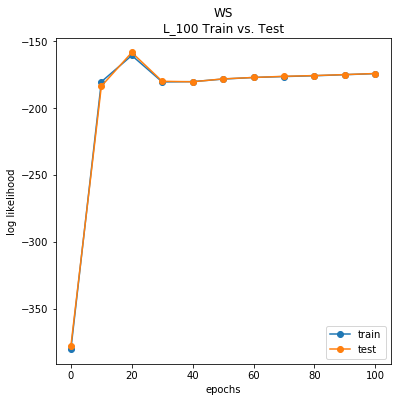

In [51]:
plot_trend(ws_train_lk,ws_test_lk,args)
plt.close('all')

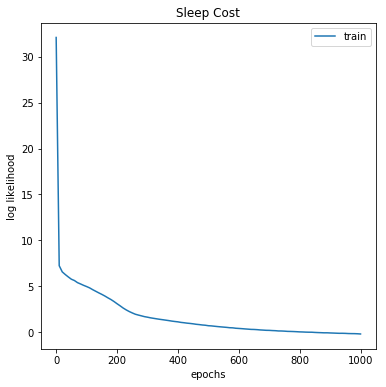

In [55]:
args['title'] = 'Sleep Cost'
args['fname'] = 'sleep_cost.png'
plot_trend(ws_sleep_cost,None,args)
plt.close('all')

## Trend Plots

## IV. Reconstructed Images

Next, we provide code that samples 100 MNIST images from the test set, uses the recognition network to map them to latent space, then applies the generator network to reconstruct the images.

**TODO**: Run this code to visualize these reconstruction samples on a $10 \times 10$ tile grid. Also visualize the original MNIST images on a $10 \times 10$ tile grid. Briefly compare the results for Wake-Sleep vs. AEVB. (You just need to uncomment the last lines to run it for Wake-Sleep.)

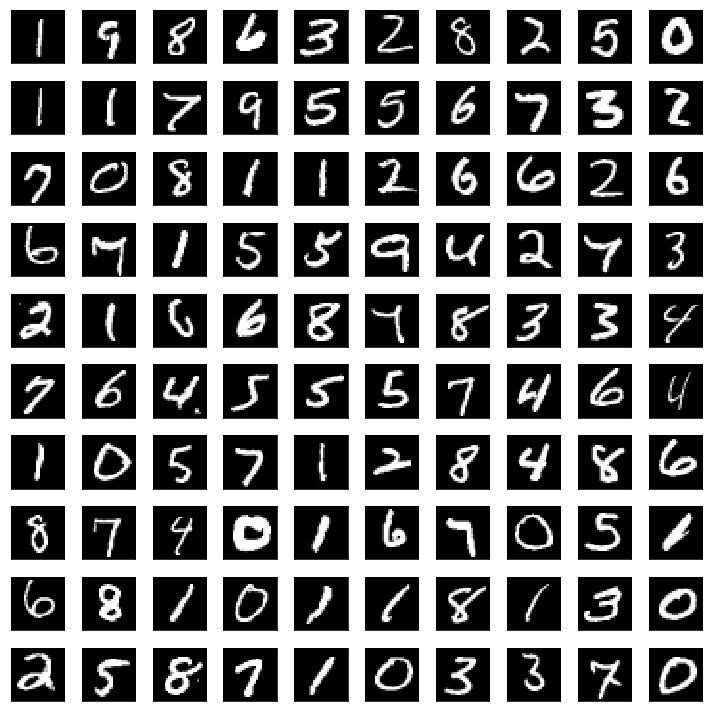

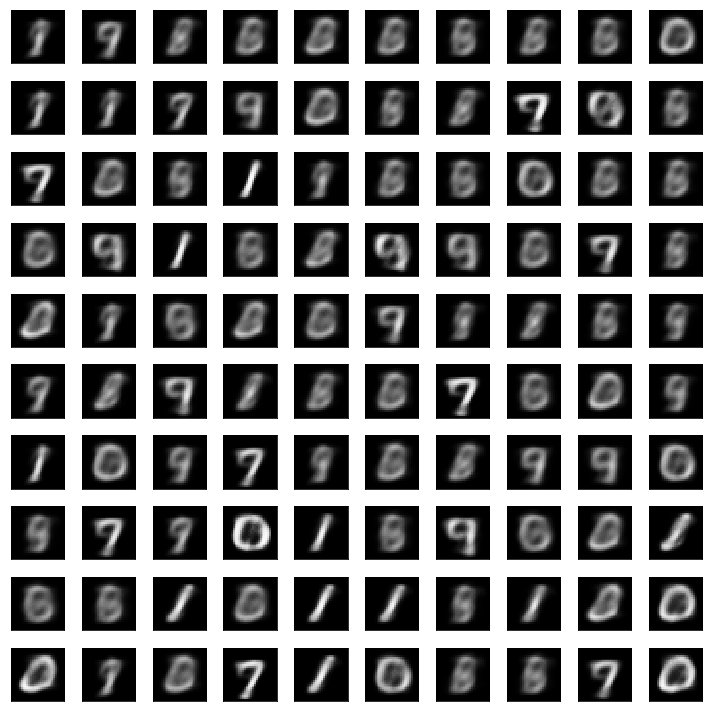

In [57]:
# Randomly sample 100 MNIST images from the test set.
x_sample = mnist.test.next_batch(100)[0]
plot_mnist(x_sample)

# Use the trained VAE model to reconstruct the images.
reconstruction = ws.reconstruct(x_sample)
plot_mnist(reconstruction, nrows=10, ncols=10)

# Use the trained Wake-Sleep model to reconstruct the images.
#reconstruction = ws.reconstruct(x_sample)
#plot_mnist(reconstruction, nrows=10, ncols=10)

In [ ]:
np.exp(-600)

## V. Latent Space Visualization (Part 1)

Since we have specifically chosen the latent space to be 2-dimensional, now we can easily visualize the learned latent manifold of digits. We provide code that samples 5000 MNIST images from the test set, and visualize their latent representations as a scatter plot, where colors of the points correspond to the digit labels.

**TODO**: Run this code to visualize the latent space scatterplot. Briefly compare the results for Wake-Sleep vs. AEVB. (You just need to uncomment the last line to run it for Wake-Sleep.)

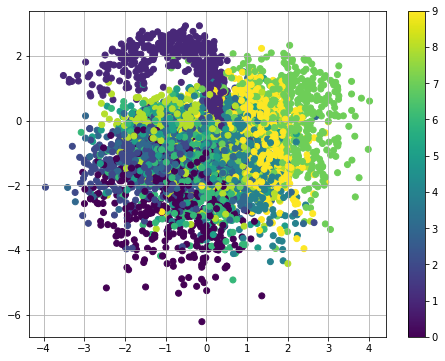

In [59]:
def plot_latent_space_scatterplot(model):
    # Scatter plot of the lagent representations of X, colored by labels.
    x_sample, y_sample = mnist.test.next_batch(5000)
    z_mu = model.transform(x_sample)
    plt.figure(figsize=(8, 6)) 
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
    plt.colorbar()
    plt.grid()
    plt.show()

plot_latent_space_scatterplot(ws)

# TODO: Do the same thing for Wake-Sleep.
#plot_latent_space_scatterplot(ws)

## VI. Latent Space Visualization (Part 2)

Finally, we provide code that uses the generator network to plot reconstructions at the positions in the latent space for which they have been generated.

The code below does the following:

1. Let $\{\mathbf{z}^{(i)} = (\mathbf{z}_1^{(i)}, \mathbf{z}_2^{(i)})\}_{i=1}^{5000}$ be the latent representations of 5000 images from the test set.

2. Let $\mathcal{Z}_1$ consist of 15 evenly spaced points between the interval $\left[ \min_i \textbf{z}_1^{(i)}, \max_i \textbf{z}_1^{(i)} \right]$, and similarly, let $\mathcal{Z}_2$ consist of 15 evenly spaced points between $\left[ \min_i \textbf{z}_2^{(i)}, \max_i \textbf{z}_2^{(i)} \right]$.

3. For each $\mathbf{z} = (\mathbf{z}_1, \mathbf{z}_2) \in \mathcal{Z}_1 \times \mathcal{Z}_2$, generate and visualize digits using the trained model, and tile the digits into a $15 \times 15$ grid.

**TODO**: Run this code to visualize the latent space reconstructions. Briefly compare the results for Wake-Sleep vs. AEVB.  (You just need to uncomment the last line to run it for Wake-Sleep.)


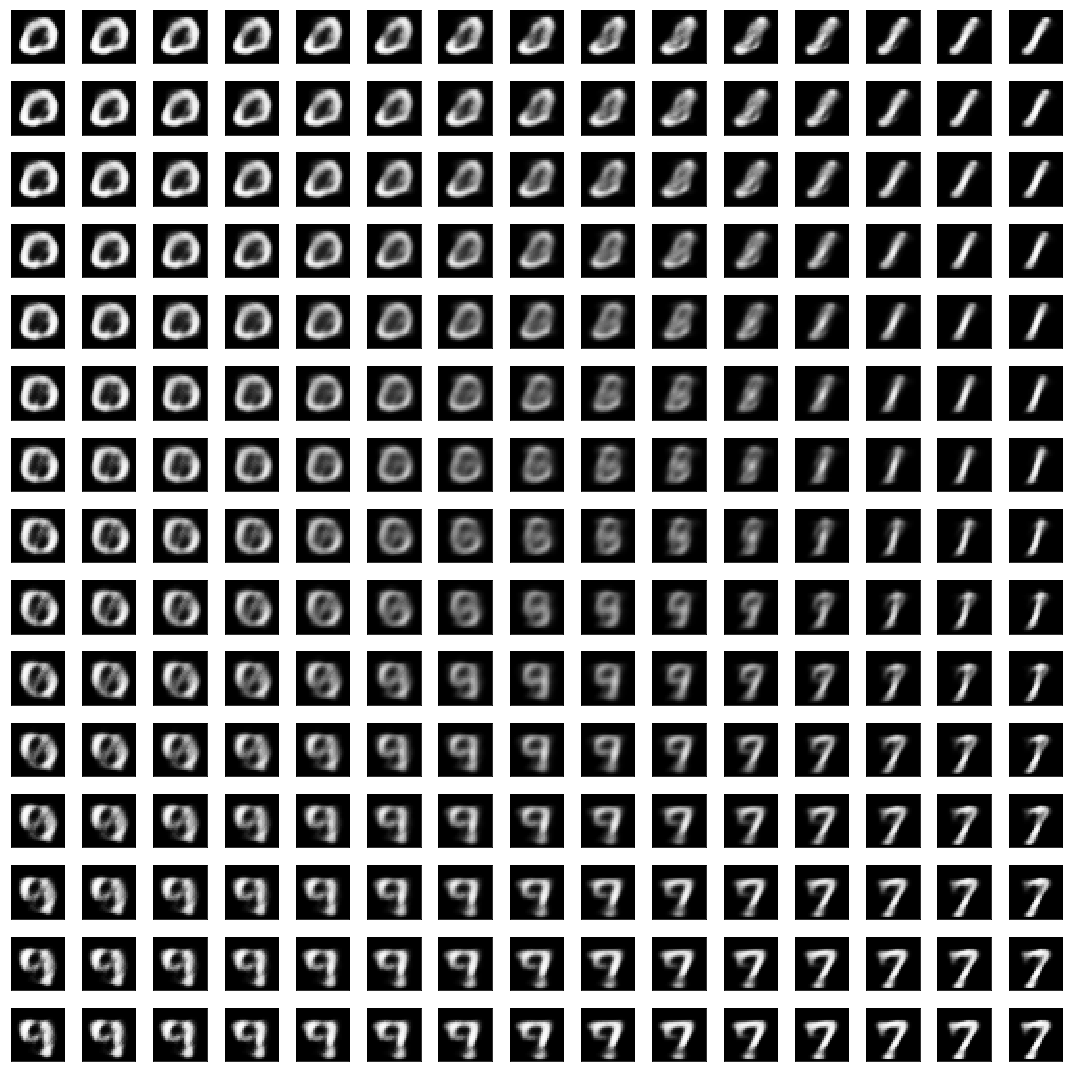

In [61]:
def plot_latent_space(X, model):
    # Plot images generated from latent space.
    z_mu = model.transform(X)
    z0_min, z1_min = np.min(z_mu, axis=0)
    z0_max, z1_max = np.max(z_mu, axis=0)
    Z = [[z0, z1] for z0 in np.linspace(z0_min, z0_max, 15)
                  for z1 in np.linspace(z1_min, z1_max, 15)]
    x_reconstr = model.generate(Z)
    plot_mnist(x_reconstr, nrows=15, ncols=15)

# Sample 100 MNIST images from the test set.
x_test, y_test = mnist.test.next_batch(5000)

plot_latent_space(x_test, ws)

# TODO: Do the same thing for Wake-Sleep.
#plot_latent_space(x_test, ws)